In [34]:
import os, glob, tarfile, tempfile, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


In [36]:
# Create extraction directory
extracted_dir = tempfile.mkdtemp(prefix="lc_extract_")

# Find all tar.gz archives in this folder
tar_files = sorted(glob.glob(os.path.join(data_dir, "*.tar.gz")))


for tarpath in tar_files:
    tf = tarfile.open(tarpath, "r:gz")
    tf.extractall(path=extracted_dir)
    tf.close()

In [12]:
#got this from looking at the files
planet_names = ["q", "s", "alpha", "rho_planet", "ds_dt", "dalpha_dt", "t_caustic"]
event_names  = ["t0", "tE", "u0_N", "u0_E", "piE_N", "piE_E", "beta", "rho_event"]

planet_entries = []
event_entries = []
meta_entries = []

# Gather all .det.lc or .det or .lc files
candidate_files = []
for root, dirs, files in os.walk(extracted_dir):
    for f in files:
        if f.endswith((".det", ".lc", ".det.lc", ".txt")):
            candidate_files.append(os.path.join(root, f))

#parsing every file
for path in candidate_files:
    base = os.path.basename(path)
    with open(path, "r", errors="ignore") as fh: #open each file!
        #store header data
        planet_vals = None
        event_vals = None
        meta = {}
        #loop through header lines (they begin with a #)
        for line in fh:
            line = line.strip()
            if not line:
                continue
            if line.startswith("#"):
                #extract the key and values
                h = line.lstrip("#").strip()
                if ":" in h:
                    key, vals = h.split(":",1)
                else:
                    parts = h.split(None,1)
                    key = parts[0]
                    vals = parts[1] if len(parts)>1 else "" #so the headers can be caught in either format (#Planet: 1 2 3 or #planet 1 2 3)
                key = key.strip()
                #convert values to floats (numbers become floats and text remains string)
                parts = vals.strip().split()
                parsed = []
                for p in parts:
                    try:
                        parsed.append(float(p))
                    except:
                        parsed.append(p)
                #save to meta
                meta[key] = parsed
                #specifically look at planet and event
                if key.lower().startswith("planet"):
                    planet_vals = parsed
                if key.lower().startswith("event"):
                    event_vals = parsed
            #stop at first non-header line        
            else:
                break

    #store parsed planet parameters
    if planet_vals is not None:
        rec = {"file": base, "path": path}
        for i,val in enumerate(planet_vals):
            name = planet_names[i] if i < len(planet_names) else f"planet_{i}"
            rec[name] = val
        planet_entries.append(rec)

    #store parsed event parameters
    if event_vals is not None:
        rec = {"file": base, "path": path}
        for i,val in enumerate(event_vals):
            name = event_names[i] if i < len(event_names) else f"event_{i}"
            rec[name] = val
        event_entries.append(rec)

    #store fs, source mag, etc
    if any(k in meta for k in ["fs", "Obssrcmag", "Sourcemag"]):
        m = {"file": base, "path": path}
        for key in meta:
            if key in ["fs","Obssrcmag","Sourcemag"]:
                m[key] = meta[key]
        meta_entries.append(m)

#create data frames
planet_df = pd.DataFrame(planet_entries)
event_df  = pd.DataFrame(event_entries)
meta_df   = pd.DataFrame(meta_entries)

#save csvs
planet_df.to_csv("planet_parameters.csv", index=False)
event_df.to_csv("event_parameters.csv", index=False)
meta_df.to_csv("meta_parameters.csv", index=False)

#print("Parsing complete.")
#print("Planet rows:", len(planet_df))
#print("Event rows:", len(event_df))


Found 427 candidate files.
Parsing complete.
Planet rows: 427
Event rows: 427


In [13]:
#This is to make sure that the columns have actual values
print("Planet columns:", planet_df.columns.tolist())
print("Event columns:", event_df.columns.tolist())

display(planet_df.head())
display(event_df.head())
display(meta_df.head())


Planet columns: ['file', 'path', 'q', 's', 'alpha', 'rho_planet', 'ds_dt', 'dalpha_dt', 't_caustic']
Event columns: ['file', 'path', 't0', 'tE', 'u0_N', 'u0_E', 'piE_N', 'piE_E', 'beta', 'rho_event']


,file,path,q,s,alpha,rho_planet,ds_dt,dalpha_dt,t_caustic
0,OMPLDG_croin_cassan_0_5_1003.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,4.495020e-07,4.04685,-42.7675,224.8880,0.000005,3.52188,27.46250
1,OMPLDG_croin_cassan_0_5_100.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,1.404600e-05,5.56198,47.1045,307.6190,0.000118,3.87735,37.97040
2,OMPLDG_croin_cassan_0_5_1041.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,6.396530e-03,1.45705,60.7581,21.6641,0.047360,1.46746,4.67624
3,OMPLDG_croin_cassan_0_5_1086.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,3.214990e-07,33.56330,-82.4818,327.9560,0.000004,27.32250,645.52600
4,OMPLDG_croin_cassan_0_5_1112.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,1.928820e-04,12.65600,-84.8398,136.5790,0.001352,11.59040,119.10800


,file,path,t0,tE,u0_N,u0_E,piE_N,piE_E,beta,rho_event
0,OMPLDG_croin_cassan_0_5_1003.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,3.224800,274.7980,1814.720643,1815.672630,-0.047035,0.038221,8.82026,0.003288
1,OMPLDG_croin_cassan_0_5_100.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,-2.089830,35.2937,281.649740,306.407388,0.008728,0.158862,10.80750,0.001375
2,OMPLDG_croin_cassan_0_5_1041.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,-0.088077,50.8302,1458.689749,1458.689749,-0.041956,2.099260,7.37122,0.001814
3,OMPLDG_croin_cassan_0_5_1086.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,27.246900,266.9190,1424.593744,1414.102396,0.047864,0.007933,7.82794,0.001295
4,OMPLDG_croin_cassan_0_5_1112.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,3.654320,341.7330,444.005482,480.804781,0.253680,0.190849,7.54640,0.001485


,file,path,fs,Sourcemag,Obssrcmag
0,OMPLDG_croin_cassan_0_5_1003.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,"[0.041137, 0.332839, 0.00813005]","[25.9715, 23.2107, 22.1027, 21.3549, 21.3513, ...","[21.3513, 23.2107, 20.9228]"
1,OMPLDG_croin_cassan_0_5_100.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,"[0.0780481, 0.0609817, 0.0219715]","[29.8611, 26.2896, 24.9251, 24.0095, 23.9541, ...","[23.9541, 26.2896, 23.2096]"
2,OMPLDG_croin_cassan_0_5_1041.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,"[0.0528173, 0.0600698, 0.0190497]","[29.188, 25.8238, 24.5062, 23.6092, 23.5505, 2...","[23.5505, 25.8238, 22.8271]"
3,OMPLDG_croin_cassan_0_5_1086.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,"[0.051975, 0.0439546, 0.0249831]","[31.2267, 27.1252, 25.5945, 24.6446, 24.6198, ...","[24.6198, 27.1252, 23.8428]"
4,OMPLDG_croin_cassan_0_5_1112.det.lc,/tmp/lc_extract_z_he44_4/OMPLDG_croin_cassan/O...,"[0.11875, 0.143745, 0.0318986]","[30.3215, 26.9246, 25.595, 24.693, 24.6408, 24...","[24.6408, 26.9246, 23.9046]"


## Planet Parameters

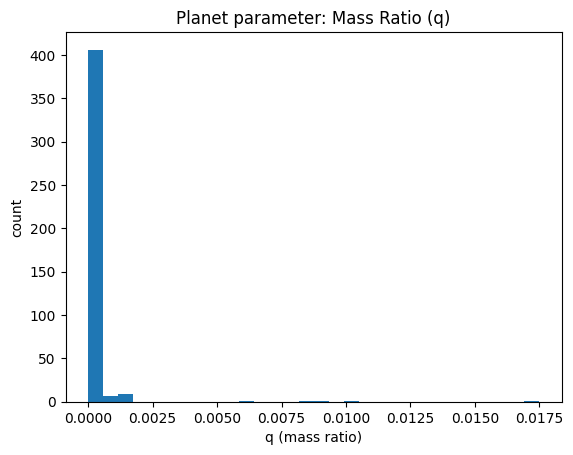

In [37]:
#planet mass ratio (q)
plt.hist(planet_df["q"].dropna(), bins=30)
plt.xlabel("q (mass ratio)")
plt.ylabel("count")
plt.title("Planet parameter: Mass Ratio (q)")
plt.show()

# q = m_planet / M_star
# x axis in log for clarity

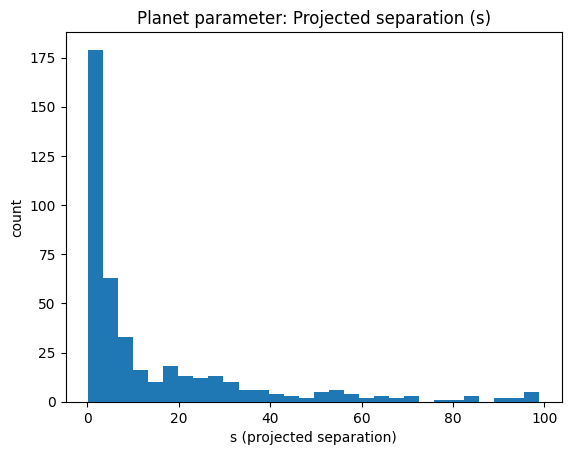

In [40]:
# Projected separation (s)
plt.hist(planet_df["s"].dropna(), bins=30)
plt.xlabel("s (projected separation)")
plt.ylabel("count")
plt.title("Planet parameter: Projected separation (s)")
plt.show()

# this is the angular separation between the lensing object (planet) and the background source star

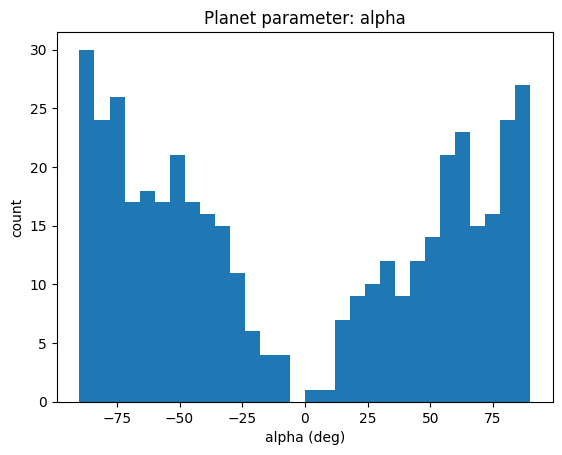

In [41]:
# alpha 
plt.hist(planet_df["alpha"].dropna(), bins=30)
plt.xlabel("alpha (deg)")
plt.ylabel("count")
plt.title("Planet parameter: alpha")
plt.show()

# alpha is the angular separation of the lens from the observer's line of sight

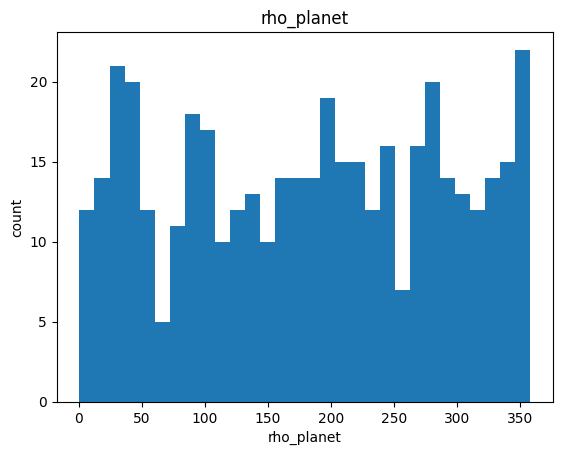

In [45]:
# rho_planet
plt.hist(planet_df["rho_planet"].dropna(), bins=30)
plt.title("rho_planet")
plt.xlabel("rho_planet")
plt.ylabel("count")
plt.show()

#the ratio of angular size of the background source star to the angular einstein radius of the lensing object (planet)

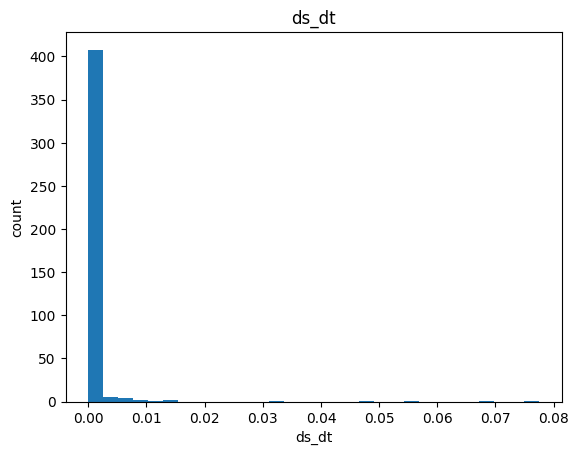

In [46]:
# ds_dt
plt.hist(planet_df["ds_dt"].dropna(), bins=30)
plt.title("ds_dt")
plt.xlabel("ds_dt")
plt.ylabel("count")
plt.show()

#the rate of change in the projected separation between the lens and the object 

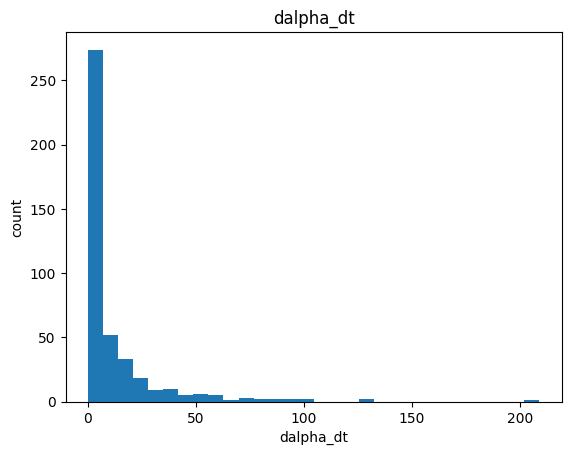

In [47]:
#dalpha_dt
plt.hist(planet_df["dalpha_dt"].dropna(), bins=30)
plt.title("dalpha_dt")
plt.xlabel("dalpha_dt")
plt.ylabel("count")
plt.show()

#the rate of change of the angle alpha (the angular separation of the lens from the observer's line of sight)

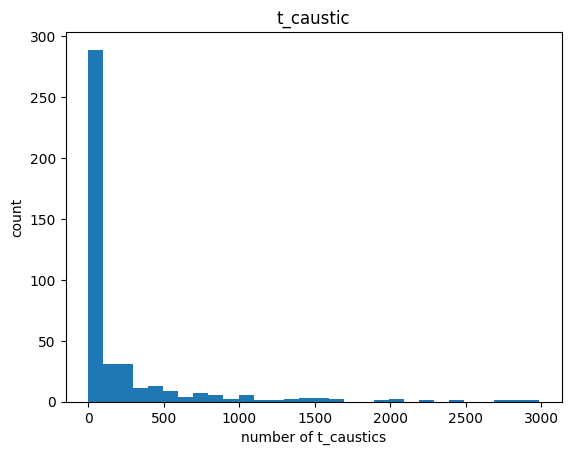

In [49]:
# t_caustic
plt.hist(planet_df["t_caustic"].dropna(), bins=30)
plt.title("t_caustic")
plt.xlabel("number of t_caustics")
plt.ylabel("count")
plt.show()

#t-caustic is a short-term, high-magnification spikes or sharp features that occur when a light source crosses a caustic

## Event Parameters

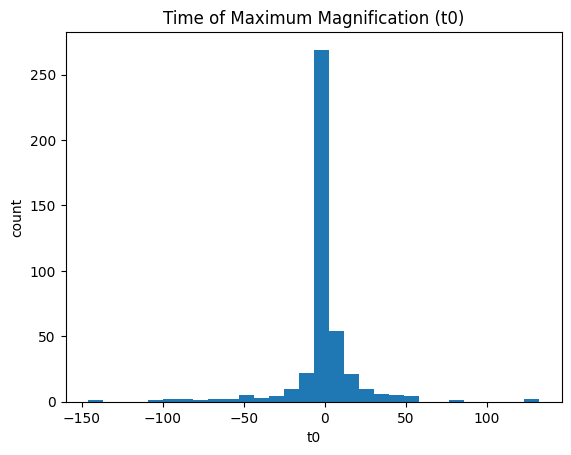

In [52]:
# t0
plt.hist(event_df["t0"].dropna(), bins=30)
plt.title("Time of Maximum Magnification (t0)")
plt.xlabel("t0")
plt.ylabel("count")
plt.show()

# t0 is the time of maximum magnification (basically alignment between the source, lens, and observer)

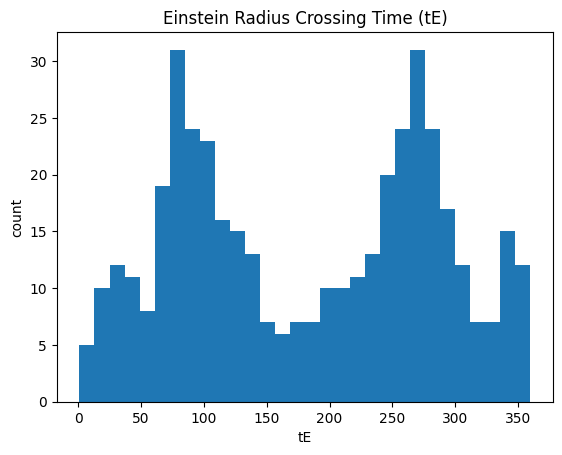

In [53]:
# tE
plt.hist(event_df["tE"].dropna(), bins=30)
plt.title("Einstein Radius Crossing Time (tE)")
plt.xlabel("tE")
plt.ylabel("count")
plt.show()

#the time taken for the lens to cross the einstein radius

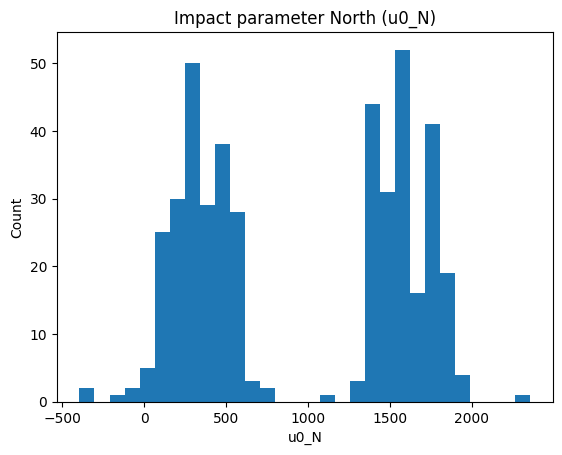

In [56]:
# u0_N
plt.hist(event_df["u0_N"].dropna(), bins=30)
plt.title("Impact parameter North (u0_N)")
plt.xlabel("u0_N")
plt.ylabel("Count")
plt.show()

#Impact parameter in the north

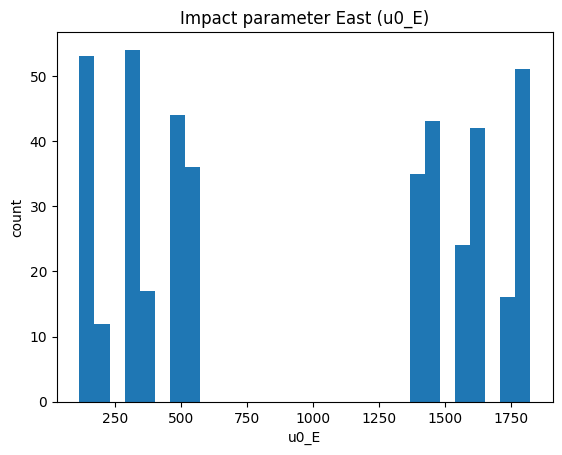

In [59]:
# u0_E
plt.hist(event_df["u0_E"].dropna(), bins=30)
plt.title("Impact parameter East (u0_E)")
plt.xlabel("u0_E")
plt.ylabel("count")
plt.show()

#Impact parameter in the east

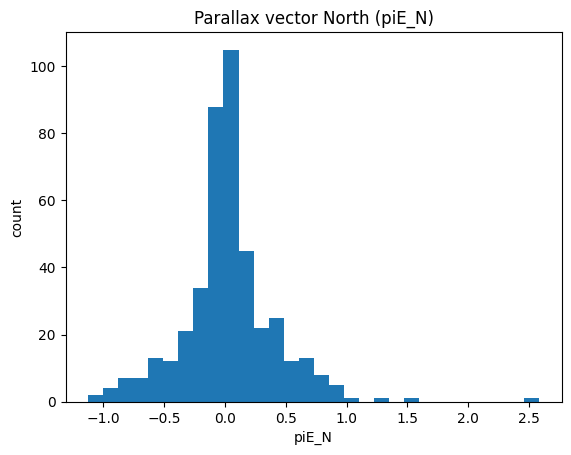

In [62]:
#piE_N
plt.hist(event_df["piE_N"].dropna(), bins=30)
plt.title("Parallax vector North (piE_N)")
plt.xlabel("piE_N")
plt.ylabel("count")
plt.show()

#microlensing parallax vector north

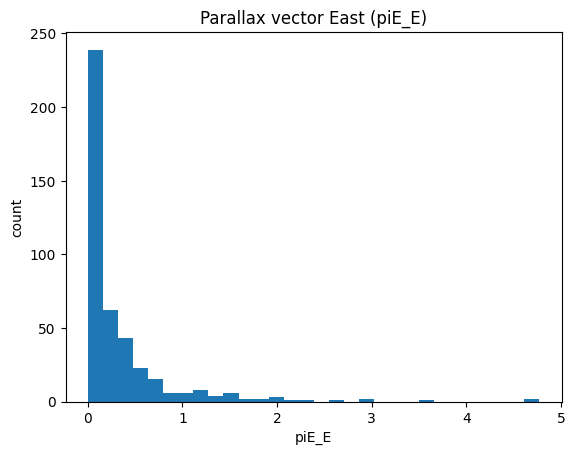

In [63]:
#piE_E
plt.hist(event_df["piE_E"].dropna(), bins=30)
plt.title("Parallax vector East (piE_E)")
plt.xlabel("piE_E")
plt.ylabel("count")
plt.show()

#microlensing parallax vector east


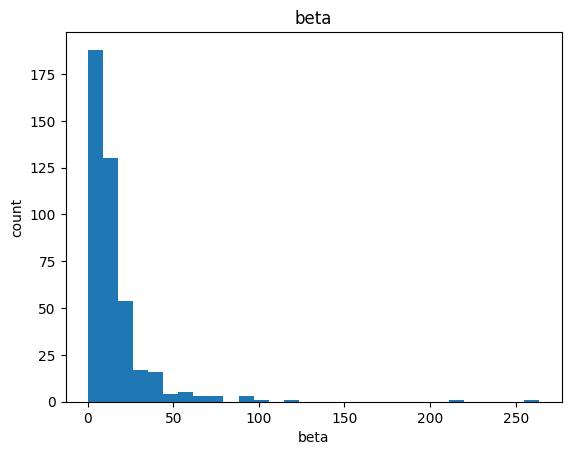

In [64]:
# beta
plt.hist(event_df["beta"].dropna(), bins=30)
plt.title("beta")
plt.xlabel("beta")
plt.ylabel("count")
plt.show()

#angle between the line of sight to the source and the lightrays from the source to the lens)

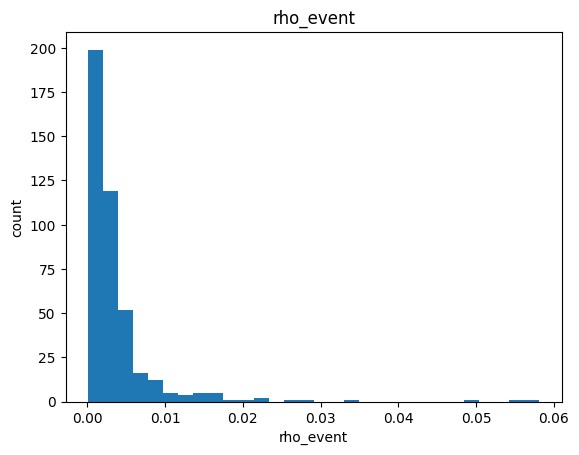

In [65]:
# rho_event
plt.hist(event_df["rho_event"].dropna(), bins=30)
plt.title("rho_event")
plt.xlabel("rho_event")
plt.ylabel("count")
plt.show()

# the ratio of the angular radius of the source star and the angular einstein radius of the lens.